# Análisis de imágenes de Sargazo

### Librerías

In [81]:
# Librería de OpenCV
import cv2
# Librería Numpy para Arrays y operaciones matriciales
import numpy as np
# Libreria para las gráficas
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Mapa de colores
from PIL import Image #Procesamiento de imagenes

from scipy.ndimage import convolve #Convolucion
from scipy.fft import fft2, ifft2, fftshift #Transformadas de Fourier

from skimage.color import label2rgb #Colorear las etiquetas en una imagen segmentada

#Filtros
from skimage.filters import sobel,laplace,unsharp_mask

### Funciones para cargar y mostrar imagenes

In [121]:
#Funcion que recibebe la direccion de la carpeta con las imagenes muestra, con un nombre base seguido de un arreglo de numeros y el tipo de archivo (debe ser la misma)
def ReadImg(folderPath,baseName,samples,fileExtension):
    images = list() #Se crea una lista vacia para contener las imagenes
    for i in samples: #Para cada imagen enumerada desde el 1
        filePath=folderPath + baseName + str(i) + fileExtension #Se crea un string para almacenar la direccion de cada imagen
        try:
            images.append(Image.open(filePath).convert("HSV")) #Se intenta agregar la imagen con el filtro gausiano a la lista
        except:
            print("No se logro agregar la imagen",filePath) #Si hay algun error, se da un aviso
            
    return images #Se regresa una lista de imagenes

In [122]:
#Mostrar varias imagenes en una sola figura
def showNImg(imgList):
    fig, plots = plt.subplots(1,len(imgList)) #Se crean las graficas en una lista de subplots

    for i in range(0,len(imgList)):
        plots[i].imshow(imgList[i]) #Se muestra cada imagen de entrenamiento

## Pruebas con la iluminación

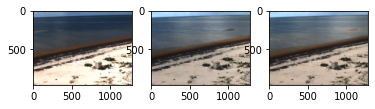

In [138]:
#Se toman imagenes de prueba con distinta iluminacion
imges = ReadImg('Test/','Test',[1,2,3],'.png')
showNImg(imges)
plt.hsv()


In [149]:
testImg = np.array(imges[2])
testImg = unsharp_mask(testImg,radius=3,amount=5,multichannel=True)

plt.imshow(testImg)
plt.hsv()

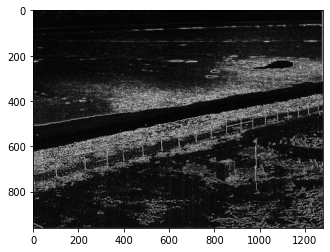

In [152]:
test2 = sobel(testImg[:,:,0])
plt.imshow(test2,cmap=cm.gray)

0.0


<ipython-input-9-7c9e9baaac25>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(fftshift(np.abs(Fimg1[:,:,2]))),cmap=cm.jet)


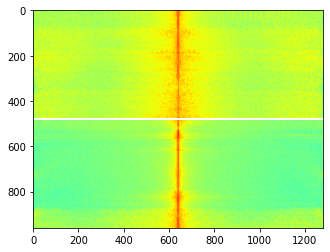

In [9]:
imgTest = np.array(imges[1])
Fimg1=fft2(imgTest)
print(np.min(abs(Fimg1)))
plt.imshow(np.log10(fftshift(np.abs(Fimg1[:,:,2]))),cmap=cm.jet)

In [24]:
dd2_5x5 = [1,0,-2,0,1]
g_5x5 = [1,4,6,4,1]
kernel = np.outer(g_5x5,dd2_5x5)
kernel = kernel + kernel.T
kernel[2,2]+=1
print(kernel)

[[  2   4   4   4   2]
 [  4   0  -8   0   4]
 [  4  -8 -23  -8   4]
 [  4   0  -8   0   4]
 [  2   4   4   4   2]]


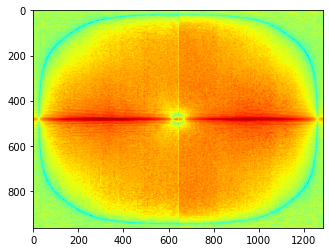

In [26]:
dim = np.add(Fimg1[:,:,0].shape,kernel.shape)-1
Fimg2=fft2(Fimg1[:,:,2],dim)
Ffiltro = fft2(kernel,dim)
res =np.multiply(Fimg2,Ffiltro)
plt.imshow(np.log10(fftshift(abs(res))),cmap=cm.jet)

[[ 142126.23446781  270692.79228388  255251.26138813  253000.04529841
   112712.3258213    21062.16983739   11392.6252834    12185.41022264
    12515.23137968   14241.67552496]
 [ 428975.10533363  249529.26196196  308950.4035559   315688.37979398
   414389.88104869   44683.21274052   18747.49538576   24906.12531189
    14267.60898798    8493.28419604]
 [ 716662.60451903  346150.62688792 1900275.49888494   93692.71533779
   782618.47322674   84786.37152153   41534.47896653   65818.31959453
    47926.95934173   58953.32908373]
 [1003822.20700481  375595.36249361 2492949.6279239    70747.5933505
  1067973.94208808  115185.17406844   51649.88534453  101755.49643385
    57303.35493262   70647.48616104]
 [1150151.16881391   91997.18772383 2236604.55316497  167835.75919359
  1173676.00073327  123443.63414925   65482.26967727  106049.04569172
    55954.46471948   51002.41386346]
 [1151807.70912336   86490.87636177 2234716.54952319  161638.39327011
  1176609.47584887  123962.91511741   78256.52

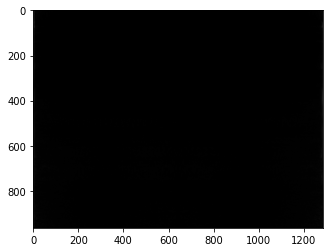

In [27]:
imgRes = ifft2(res)
plt.imshow(abs(imgRes),cmap=cm.gray)
print(abs(imgRes[:10,:10]))

## Pruebas con superpixeles

In [24]:
def imagetoSP(img):
    # Crear el objeto de SLIC con las propiedades especificadas
    slic = cv2.ximgproc.createSuperpixelSLIC(img, algorithm = cv2.ximgproc.SLIC, region_size = 20, ruler = 20.0)
    # Iterar el algoritmo
    slic.iterate()
    # Obtener la máscara de los ejes de los Super pixeles
    mask_slic = slic.getLabelContourMask()
    # Obtener un numpy array con los indices de los superpixeles
    label_slic = slic.getLabels()
    # Obtener el número de Super pixeles generados
    number_slic = slic.getNumberOfSuperpixels()
    # Negar la máscara de los superpixeles para poder haceer operaciones con esta
    mask_inv_slic = cv2.bitwise_not(mask_slic)  
    # Hacer la operación booleana de la máscara de Super Pixeles y la imagen original
    img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic)
    # RESULTADOS
    return img_slic, label_slic, number_slic

In [25]:
slicIm, lblSlic, n_Slic = imagetoSP(np.array(imges[0]))

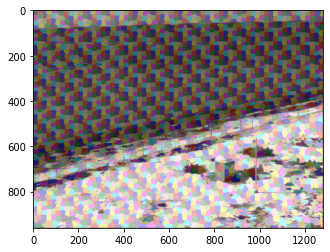

In [28]:
color1 = label2rgb(lblSlic, image=np.array(imges[0]), bg_label=0)
plt.imshow(color1)